# Tutorial - Green Urban Scenarious
A demo of a minimal flow of GUS process.

For more advanced use cases, please see upcoming article. For more structured experiment and scenario analyis plese see model sepcification and code documentation within docs/ folder. 

In [1]:
# Install the GUS framework.

import sys

!{sys.executable} -m pip install pygus


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 3
%matplotlib inline
from pkg_resources import resource_filename
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json
import pkgutil
import pprint

root_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

pp = pprint.PrettyPrinter(indent=1)
sns.set_theme()

/var/folders/sq/279ztff55tg817zzbvzd4p0c0000gn/T/ipykernel_30988/1735931772.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


## 0. Importing GUS modules

In [3]:
from pygus.gus.models import Urban, SiteConfig
from pygus.gus.utilities import get_raster_data

## 1. Initilisation

### 1.1 Importing data on site, tree populations, experiment parameters

In [4]:
# File that holds site/city other geolocated data and parameters
fname_config_site = os.path.join(root_dir, "pygus", "gus", "inputs", "site.json")

# File that include tree species specific parameters
# resource_filename("pygus", "gus/inputs/allometrics.json")
fname_config_allometrics = os.path.join(
    root_dir, "pygus", "gus", "inputs", "allometrics.json"
)

# File that include individual tree data including their location on a 2D raster of the actual location
# resource_filename("pygus", "gus/inputs/trees.csv")
fname_data_trees = os.path.join(root_dir, "pygus", "gus", "inputs", "trees.csv")

# File that holds experiment parameters
# resource_filename("pygus", "gus/inputs/scenario.json")
fname_scenario_params = os.path.join(
    root_dir, "pygus", "gus", "inputs", "scenario.json"
)

In [5]:
f = open(fname_config_allometrics)
config_allometrics = json.loads(f.read())
# pp.pprint(config_allometrics)

In [6]:
f = open(fname_config_site)
config_site = json.loads(f.read())
# config_site = SiteConfig(**config_site)
pp.pprint(config_site)

{'impervious_m2': 500,
 'pervious_m2': 500,
 'project_site_type': 'park',
 'total_m2': 1000,
 'tree_density_per_ha': 400,
 'weather': {'growth_season_mean': 200, 'growth_season_var': 7}}


In [7]:
df_pop = pd.read_csv(fname_data_trees)
df_pop.tail()

,id,species,dbh,height,condition,xpos,ypos
95,96,conifer,13.871098,3.303454,good,17,4
96,97,conifer,12.561324,3.165903,good,17,5
97,98,conifer,13.651542,3.436859,good,17,6
98,99,conifer,12.610441,3.195499,good,17,3
99,100,conifer,12.491068,3.467151,excellent,17,7


In [8]:
f = open(fname_scenario_params)
scenario_params = json.loads(f.read())
pp.pprint(scenario_params)

{'is_crownsunexposure_fixed': 1,
 'maintenance_scope': 1,
 'time_horizon_years': 50}


### 1.2 Creating a digital twin of the site

In [9]:
site = Urban(df_pop, fname_config_allometrics, fname_config_site, scenario_params)

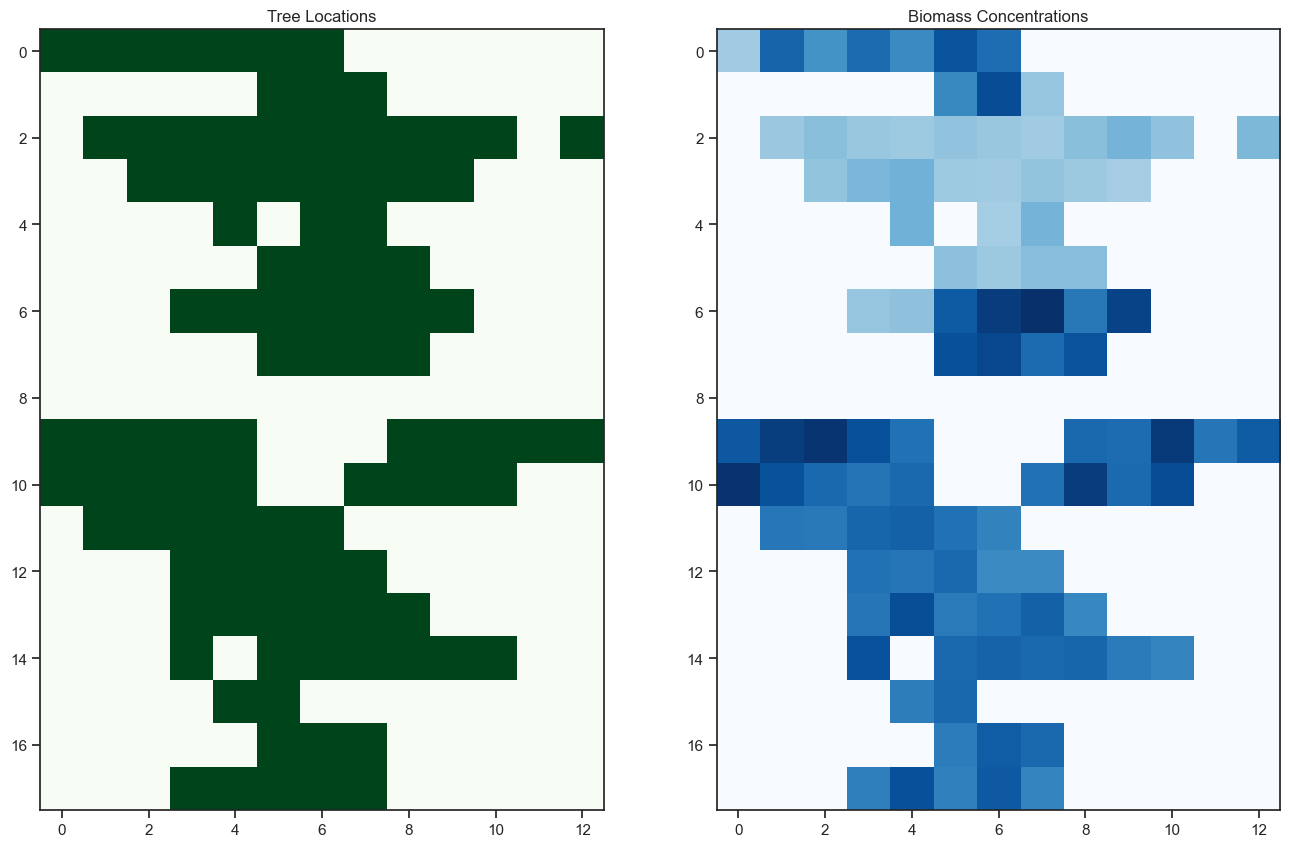

In [10]:
initial_locations = get_raster_data(site, counts=True)
initial_biomass = get_raster_data(site, var="biomass")

sns.set_style("ticks")
fig = plt.figure(figsize=(16, 12))
plt.subplot(121)
plt.imshow(initial_locations, cmap="Greens")
plt.title("Tree Locations")
plt.subplot(122)
plt.title("Biomass Concentrations")
plt.imshow(initial_biomass, cmap="Blues")
# plt.colorbar(label = 'Biomass - Kg')
plt.show()

## 2. Running the scenario

In [11]:
for i in range(scenario_params["time_horizon_years"]):
    site.step()

## 3. Analysis

### 3.1 Individual tree level inspections 

In [12]:
# Tree level individual variables
df_out_tree = site.datacollector.get_agent_vars_dataframe()
# df_out_tree.to_csv("trees_yearly.json", index=True)
df_out_tree.tail()

species       dbh    height    crownH    crownW  canopy_overlap  \
Step AgentID                                                                    
50   363      conifer  9.307092  5.940430  3.835347  2.388317             0.0   
     364      conifer  8.773924  5.634695  3.692496  2.287569             0.0   
     365       decidu  9.139867  8.287582  4.241358  3.674543             0.0   
     366       decidu  9.503089  8.464893  4.342184  3.761308             0.0   
     367       decidu  9.677719  8.549037  4.390442  3.802870             0.0   

               cle  condition   dieback    biomass  seq     carbon  deroot  \
Step AgentID                                                                 
50   363      0.56  excellent  0.005486  29.442204  0.0  14.721102     0.0   
     364      0.56  excellent  0.000459  25.486104  0.0  12.743052     0.0   
     365      0.56  excellent  0.003362  34.407342  0.0  17.203671     0.0   
     366      0.56  excellent  0.008678  37.560897  0.0  18.780448     0.0   
     367      0.56  excellent  0.004325  39.131923  0.0  19.565962     0.0   

              detrunk  mulched  burnt coordinates       est_age  
Step AgentID                                                     
50   363          0.0      0.0    0.0     (14, 3)  8.378963e-10  
     364          0.0      0.0    0.0     (13, 8)  6.702881e-10  
     365          0.0      0.0    0.0      (5, 8)  2.699507e-02  
     366          0.0      0.0    0.0     (10, 2)  3.072258e-02  
     367          0.0      0.0    0.0      (2, 6)  3.266731e-02

In [13]:
Specific_Tree = df_out_tree.xs(42, level="AgentID")
Specific_Tree.tail()

,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,dieback,biomass,seq,carbon,deroot,detrunk,mulched,burnt,coordinates,est_age
Step,,,,,,,,,,,,,,,,,,
46,decidu,15.794101,11.154953,5.99197,5.19603,0.431685,0.832853,replaced,1.0,117.815449,0.0,58.907725,0.0,0.0,0.0,0.0,"(6, 8)",4.072032
47,decidu,15.794101,11.154953,5.99197,5.19603,0.431685,0.832853,replaced,1.0,117.815449,0.0,58.907725,0.0,0.0,0.0,0.0,"(6, 8)",4.072032
48,decidu,15.794101,11.154953,5.99197,5.19603,0.431685,0.832853,replaced,1.0,117.815449,0.0,58.907725,0.0,0.0,0.0,0.0,"(6, 8)",4.072032
49,decidu,15.794101,11.154953,5.99197,5.19603,0.431685,0.832853,replaced,1.0,117.815449,0.0,58.907725,0.0,0.0,0.0,0.0,"(6, 8)",4.072032
50,decidu,15.794101,11.154953,5.99197,5.19603,0.431685,0.832853,replaced,1.0,117.815449,0.0,58.907725,0.0,0.0,0.0,0.0,"(6, 8)",4.072032


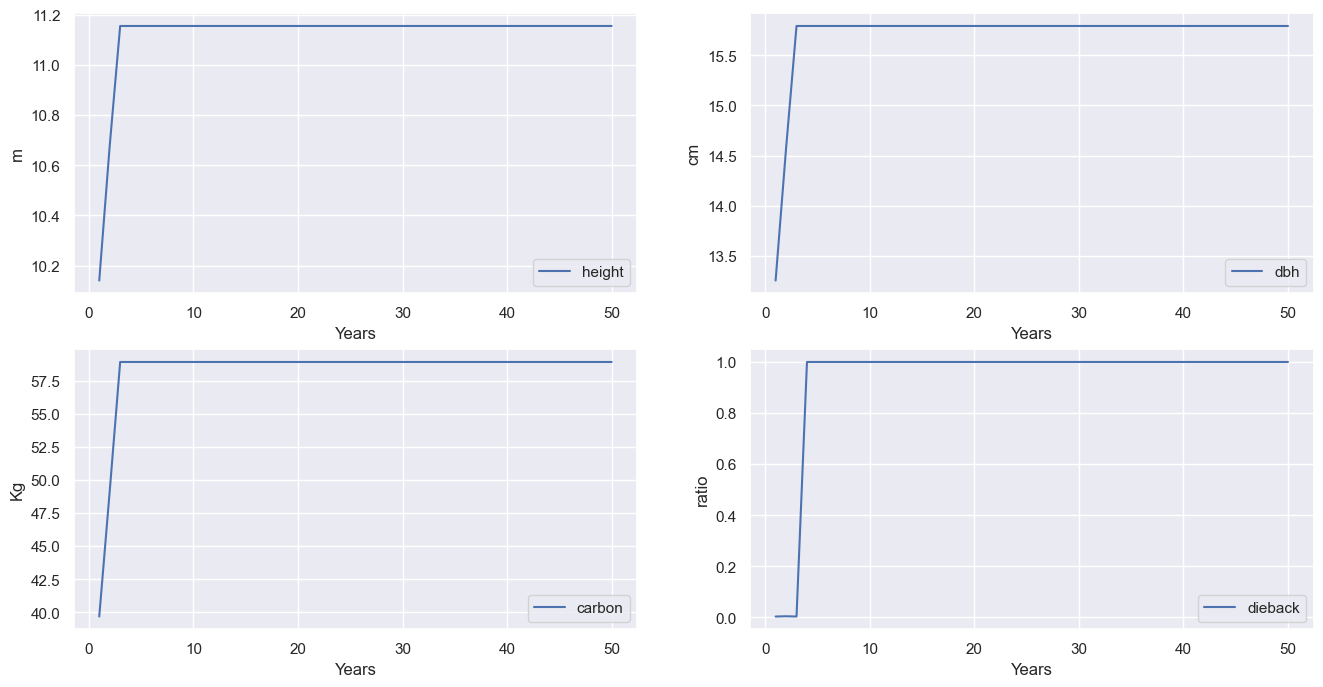

In [14]:
sns.set_theme()
fig = plt.figure(figsize=(16, 8))
plt.subplot(221)
Specific_Tree.height.plot()
plt.xlabel("Years")
plt.ylabel("m")
plt.legend()
plt.subplot(222)
Specific_Tree.dbh.plot()
plt.xlabel("Years")
plt.ylabel("cm")
plt.legend()
plt.subplot(223)
Specific_Tree.carbon.plot()
plt.xlabel("Years")
plt.ylabel("Kg")
plt.legend()
plt.subplot(224)
Specific_Tree.dieback.plot()
plt.xlabel("Years")
plt.ylabel("ratio")
plt.legend()
plt.show()

### 3.2 Site level inspections

In [15]:
# Site level aggregate variables
df_out_site = site.datacollector.get_model_vars_dataframe()
df_out_site.tail()

,Storage,Seq,Avg_Seq,Released,Avg_Rel,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std
45,45998.430700,758.180122,8.816048,166.960751,1.892087,86,14,0,0,0,241,5.011100
46,46899.214708,744.655326,8.094080,261.125769,2.801030,92,8,0,0,0,251,4.937224
47,47696.526798,763.379051,8.674762,905.011197,10.781260,88,12,0,0,0,253,5.001433
48,48530.669145,776.038192,9.023700,438.275160,5.465736,86,14,0,0,0,257,5.182777
49,49450.938724,754.950315,8.296157,322.278974,2.886041,91,9,0,0,0,267,4.999830


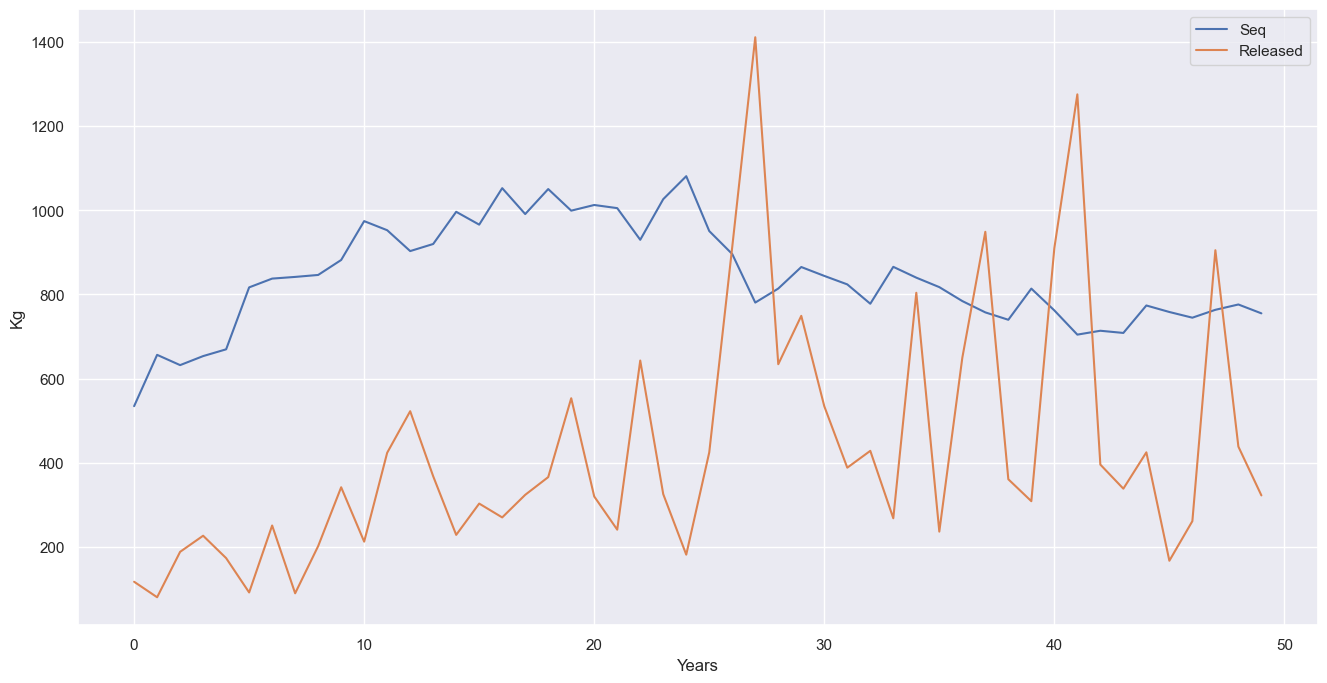

In [16]:
fig = plt.figure(figsize=(16, 8))
df_out_site.Seq.plot()
df_out_site.Released.plot()
plt.xlabel("Years")
plt.ylabel("Kg")
plt.legend()
plt.show()

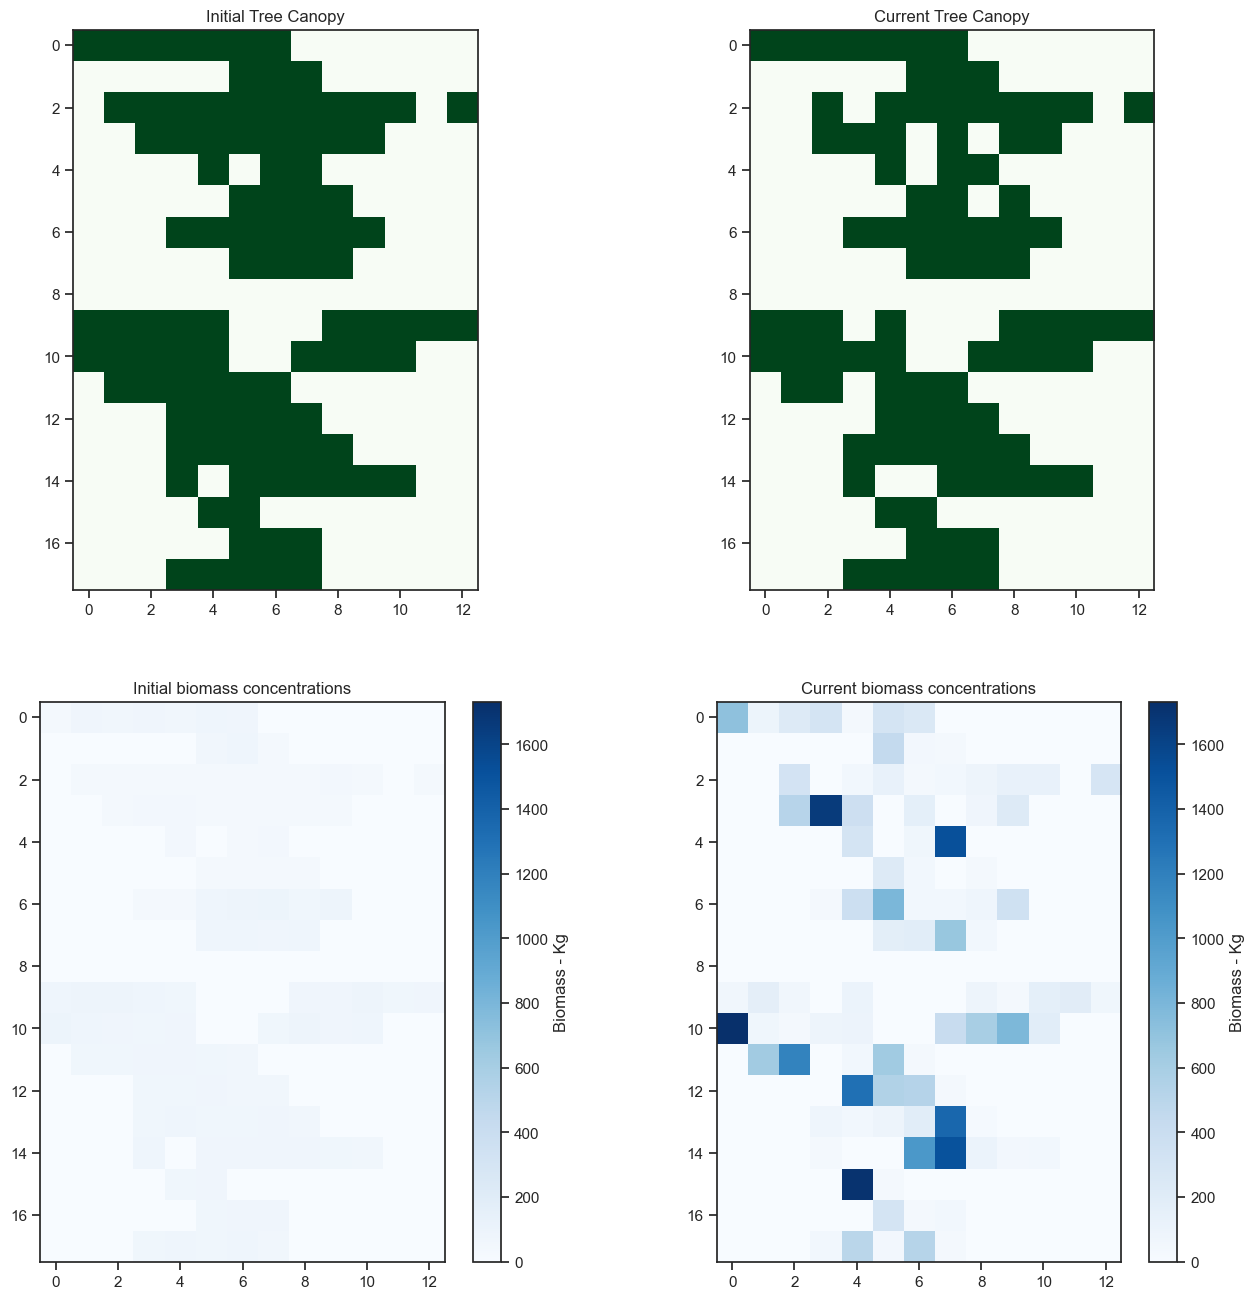

In [17]:
locations = get_raster_data(site, counts=True)
biomass = get_raster_data(site, var="biomass")

sns.set_style("ticks")
fig = plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.imshow(initial_locations, cmap="Greens")
plt.title("Initial Tree Canopy")

plt.subplot(222)
plt.imshow(locations, cmap="Greens")
plt.title("Current Tree Canopy")

plt.subplot(223)
plt.title("Initial biomass concentrations")
plt.imshow(initial_biomass, cmap="Blues", vmin=0, vmax=biomass.max())
plt.colorbar(label="Biomass - Kg")

plt.subplot(224)
plt.title("Current biomass concentrations")
plt.imshow(biomass, cmap="Blues")
plt.colorbar(label="Biomass - Kg")
plt.show()